In [1]:
import torch
from torch.utils.data import DataLoader
from torch import optim
import torchvision
#from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms

import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from itertools import product
from copy import copy


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [3]:
device

device(type='cuda')

In [4]:
transform = transforms.Compose([transforms.ToTensor()])

dataset = torchvision.datasets.SVHN(root='/data/torchvision', split='train' ,download=True, transform=transform)


Using downloaded and verified file: /data/torchvision/train_32x32.mat


In [5]:
dataset

Dataset SVHN
    Number of datapoints: 73257
    Root location: /data/torchvision
    Split: train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [6]:
test = torchvision.datasets.SVHN(root='/data/torchvision', split='test', download=True, transform=transform)


Using downloaded and verified file: /data/torchvision/test_32x32.mat


In [7]:
test

Dataset SVHN
    Number of datapoints: 26032
    Root location: /data/torchvision
    Split: test
    StandardTransform
Transform: Compose(
               ToTensor()
           )

In [8]:
train_size = int(len(dataset)*0.8)
validation_size = len(dataset) - train_size

train, validation = torch.utils.data.random_split(dataset, [train_size, validation_size])

In [9]:
len(train), len(validation)


(58605, 14652)

In [10]:
train_data_loader = DataLoader(train, batch_size=64)


In [11]:
images, targets = next(iter(train_data_loader))


In [12]:
images.size()


torch.Size([64, 3, 32, 32])

In [13]:
len(torch.flatten(images[0]))


3072

In [14]:
def convert_tensor_to_array(tensor):
    image = np.asarray(tensor)
    # move the first axis to the end
    image = np.rollaxis(image, 0, 3)
    return image

In [15]:
def plot_batch(images, targets):
    rows, cols = 8, 8
    fig, axs = plt.subplots(rows, cols, figsize=(10, 12))

    for i, (fig_row, fig_col) in enumerate(product(range(rows), range(cols))):
    
        tensor = images[i]

        img = convert_tensor_to_array(tensor)

        ax = axs[fig_row, fig_col]
        ax.imshow(img)

        ax.set_title(int(targets[i]))

        ax.axis('off')

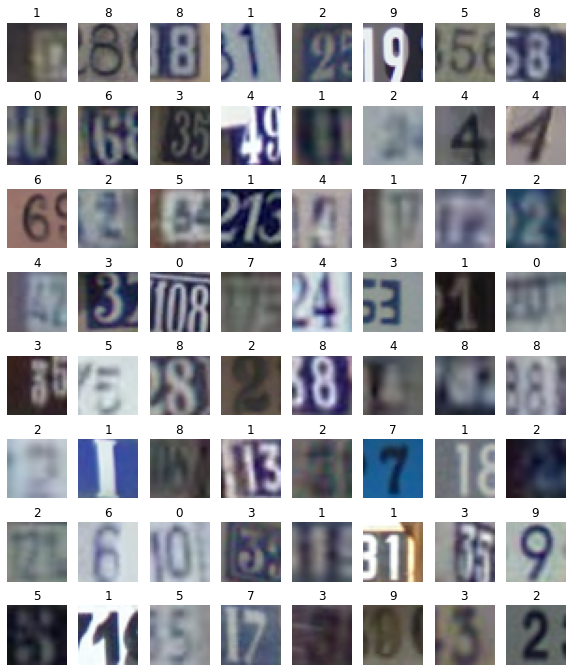

In [16]:
plot_batch(images, targets)


In [17]:
def get_data(train_ds, valid_ds, bs):
    return (
        DataLoader(train_ds, batch_size=bs, shuffle=True),
        DataLoader(valid_ds, batch_size=bs * 2),
    )

In [18]:
def loss_batch(model_output, loss_func, xb, yb, opt=None): #calculat loss of train
    
    output = loss_func(model_output, yb)

    if opt is not None:
        output.backward()
        opt.step()
        opt.zero_grad()

    return output.item(), len(xb)

In [19]:
def loss_batches(model, data_loader, loss_func, opt=None):
    correct = 0
    losses, batch_sizes = [], []
  
    for xb, yb in data_loader:
    
        xb, yb = xb.to(device), yb.to(device)
        model_output = model(xb)
        _, y_predict = torch.max(model_output.data, 1)
        correct += (y_predict == yb).sum().item()

        loss, batch_size = loss_batch(model_output, loss_func, xb, yb, opt)
        
        losses.append(loss)
        batch_sizes.append(batch_size)

    return correct, losses, batch_sizes

In [20]:
def calc_loss(losses, nums):
    return np.sum(np.multiply(losses, nums)) / np.sum(nums)

In [21]:
def accuracy(correct, batch_sizes):
    return correct/np.sum(batch_sizes)

In [22]:
def train_epoch(model, data_loader, loss_func, eval_func, opt):
  
    model.train()
    correct, losses, batch_sizes = loss_batches(model, data_loader, loss_func, opt)
    return eval_func(correct, batch_sizes), calc_loss(losses, batch_sizes)
     

In [23]:
def validate_epoch(model, data_loader, loss_func, eval_func, opt):
    model.eval()
    with torch.no_grad():
        correct, losses, batch_sizes = loss_batches(model, data_loader, loss_func)
        
    return eval_func(correct, batch_sizes), calc_loss(losses, batch_sizes)

In [24]:
def fit(epochs, model, loss_func, opt, train_dl, valid_dl):

    train_losses, valid_losses = [], []
    train_accs, valid_accs = [], []

    for epoch in range(epochs):

        train_acc, train_loss = train_epoch(model, train_dl, loss_func, accuracy, opt)
        train_accs.append(train_acc)
        train_losses.append(train_loss)

        valid_acc, val_loss = validate_epoch(model, valid_dl, loss_func, accuracy, opt) 
        valid_accs.append(valid_acc)
        valid_losses.append(val_loss)

        print(epoch, f'train_loss={train_loss}\tval_loss={val_loss}')

    return train_losses, valid_losses, train_accs, valid_accs

In [25]:
def plot_loss(title, epochs, train_losses, val_losses):
    plt.plot(range(epochs), train_losses, label='Train')
    plt.plot(range(epochs), val_losses, label='Test')
    plt.legend()
    plt.title(title)
    plt.xlabel('epochs')

In [26]:
def get_model_cnn():
    
    in_channels = 3 #RGB

    H, D_out = 64, 10
    model = torch.nn.Sequential(
        torch.nn.Conv2d(3, 6, kernel_size=5, stride=1, padding=0),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 3, stride = 2),
            
        torch.nn.Conv2d(6, 16, kernel_size=5, stride=1, padding=0),
        torch.nn.ReLU(),
        torch.nn.MaxPool2d(kernel_size = 3, stride = 2),

        torch.nn.Flatten(),
        torch.nn.Linear(256,120),
        torch.nn.ReLU(),
        torch.nn.Linear(120,64),
        torch.nn.ReLU(),
        torch.nn.Linear(H, D_out),
        torch.nn.Softmax(dim=1),
    )
    model.to(device)
    
    return model, optim.SGD(model.parameters(), lr=0.001)

In [27]:
batch_size = 64
epochs = 1
loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train, validation, batch_size)
model, opt = get_model_cnn()
train_losses, val_losses, train_accs, valid_accs = fit(epochs, model, loss_fn, opt, train_dl, valid_dl)

0 train_loss=2.3037575512471005	val_loss=2.3036693476797483


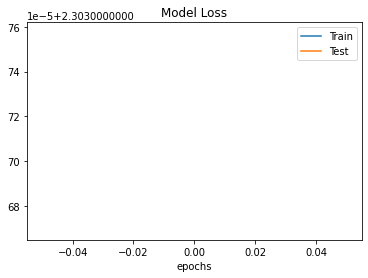

In [28]:
plot_loss('Model Loss', epochs, train_losses, val_losses)


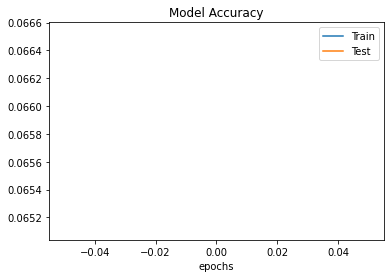

In [29]:
plot_loss('Model Accuracy', epochs, train_accs, valid_accs)


In [30]:
#loss_fn = torch.nn.CrossEntropyLoss()

test_data_loader = DataLoader(test, batch_size=64)
accuracy1, loss = validate_epoch(model, test_data_loader, loss_fn, accuracy, opt=None)

accuracy1

0.06488168408113092

In [31]:
valid_accs[-1]

0.06511056511056511

In [32]:
#torch.save(model.state_dict(), "saved__model.pt")


In [33]:
def get_model_cnn_improved():
    
    in_channels = 3 #RGB

    H, D_out = 64, 10

    model = torch.nn.Sequential(
      torch.nn.Conv2d(in_channels, 32, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
        
      torch.nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(64),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Dropout(p=0.5),
        
      torch.nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
      torch.nn.ReLU(),
      torch.nn.BatchNorm2d(128),
      torch.nn.MaxPool2d(kernel_size=2, stride=2),
      torch.nn.Dropout(p=0.5),
        
      torch.nn.Flatten(),
      torch.nn.Linear(4*4*128, H),
      torch.nn.ReLU(),
      torch.nn.Linear(H, D_out),
    )

    model.to(device)
     
    return model, optim.Adam(model.parameters(), lr=0.001)

In [34]:
batch_size = 64
epochs = 50
#loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train, validation, batch_size)
model_cnn_improved, opt = get_model_cnn_improved()

train_losses1, val_losses1, train_accs1, valid_accs1 = fit(epochs, model_cnn_improved, loss_fn, opt, train_dl, valid_dl)

0 train_loss=1.1028266185898898	val_loss=0.5057453252466656
1 train_loss=0.5917139601304704	val_loss=0.39776216710554324
2 train_loss=0.5173091618653278	val_loss=0.3682487750928844
3 train_loss=0.4708592712365567	val_loss=0.3461333144046295
4 train_loss=0.43371050640458836	val_loss=0.37373577498068355
5 train_loss=0.4150783709043245	val_loss=0.31093821178896974
6 train_loss=0.395863149936223	val_loss=0.3162554427798316
7 train_loss=0.3847146295136269	val_loss=0.30246523614141935
8 train_loss=0.3669215344897554	val_loss=0.30344662412801726
9 train_loss=0.353443783738794	val_loss=0.309244197564733
10 train_loss=0.3460619054715001	val_loss=0.28521482867765646
11 train_loss=0.3355560405080854	val_loss=0.3037581155770729
12 train_loss=0.3311462572517782	val_loss=0.2933775694553168
13 train_loss=0.32059339572927487	val_loss=0.2754124377167944
14 train_loss=0.3162948161071198	val_loss=0.2805037336648243
15 train_loss=0.30872651252788486	val_loss=0.281027484185833
16 train_loss=0.3080700506794

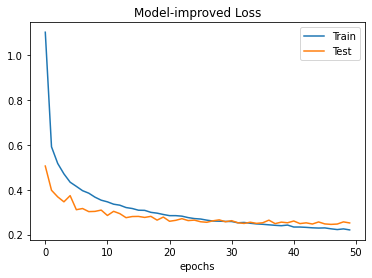

In [35]:
plot_loss('Model-improved Loss', epochs, train_losses1, val_losses1)


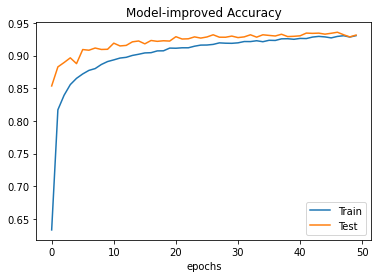

In [36]:
plot_loss('Model-improved Accuracy', epochs, train_accs1, valid_accs1)


In [37]:
valid_accs1[-1]


0.9314769314769314

In [38]:
test_data_loader = DataLoader(test, batch_size=64)
accuracy_test, loss_test = validate_epoch(model_cnn_improved, test_data_loader, loss_fn, 
                                          accuracy, opt=None)

accuracy_test

0.9306238475722188

In [39]:
train_transformed = copy(train)
train_transformed.dataset = copy(dataset)
 
train_transformed.dataset.transform = torchvision.transforms.Compose([
    torchvision.transforms.ColorJitter(0.2, 0.2, 0.2, 0.2),
    torchvision.transforms.RandomAffine(degrees=30),
    torchvision.transforms.ToTensor(),
    ])

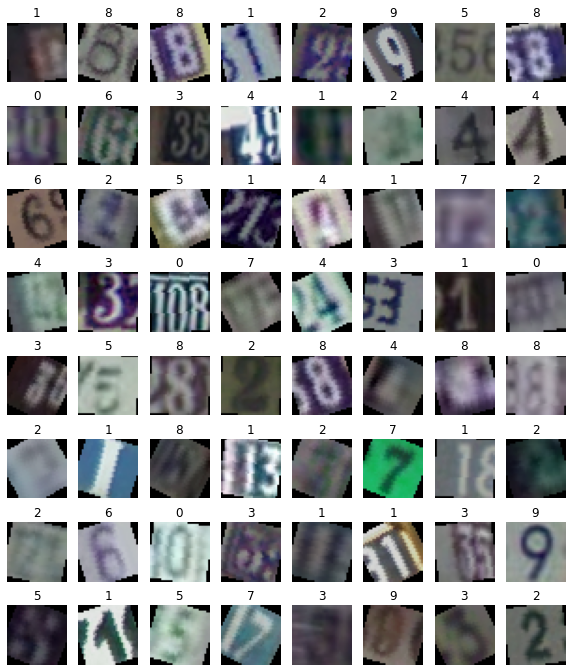

In [40]:
transformed_train_dl = DataLoader(train_transformed, batch_size=64)

images_transformed, targets = next(iter(transformed_train_dl))

plot_batch(images_transformed, targets)

In [41]:
batch_size = 64
epochs = 20
#loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train_transformed, validation, batch_size)
model_cnn_improved2, opt = get_model_cnn_improved()

train_losses2, val_losses2, train_accs2, valid_accs2 = fit(epochs, model_cnn_improved2, loss_fn, opt, train_dl, valid_dl)

0 train_loss=1.5202968473473504	val_loss=0.6830820003852407
1 train_loss=0.8832481938370177	val_loss=0.5290484045767699
2 train_loss=0.7568525354016632	val_loss=0.4757899017793508
3 train_loss=0.6895199859135184	val_loss=0.4467055282484076
4 train_loss=0.6554077845904904	val_loss=0.40649159754230585
5 train_loss=0.6211776867609322	val_loss=0.4242537951261139
6 train_loss=0.5948264166607241	val_loss=0.3835173057640897
7 train_loss=0.576245599263012	val_loss=0.365763583658108
8 train_loss=0.5646960827822409	val_loss=0.3617127716394842
9 train_loss=0.5500531050168495	val_loss=0.3461410906954017
10 train_loss=0.5350823396297356	val_loss=0.35254841180502505
11 train_loss=0.5282255951947965	val_loss=0.3362476172796729
12 train_loss=0.5186123029639641	val_loss=0.3495699376673312
13 train_loss=0.5088315772324757	val_loss=0.31896928081722686
14 train_loss=0.5053582847560798	val_loss=0.3229338241638852
15 train_loss=0.4910550899096148	val_loss=0.30815761149490983
16 train_loss=0.4878833744664432

In [42]:
valid_accs2[-1]


0.9114796614796615

In [43]:
test_data_loader = DataLoader(test, batch_size=64)
accuracy_test, loss_test = validate_epoch(model_cnn_improved2, test_data_loader, loss_fn, 
                                          accuracy, opt=None)

accuracy_test

0.9102642901044868

In [44]:
batch_size = 64
epochs = 10
#loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train_transformed, validation, batch_size)
model_cnn_improved_lr1, __ = get_model_cnn_improved()
opt = optim.Adam(model_cnn_improved_lr1.parameters(), lr=0.01)

train_losses6, val_losses6, train_accs6, valid_accs6 = fit(epochs, model_cnn_improved_lr1, loss_fn, opt, train_dl, valid_dl)

0 train_loss=2.263887598485876	val_loss=2.234837084951669
1 train_loss=2.238129061381673	val_loss=2.2336658735663195
2 train_loss=2.2380468881493307	val_loss=2.2342033972025503
3 train_loss=2.238095651451165	val_loss=2.2338382798792917
4 train_loss=2.2381745637251385	val_loss=2.2346780418601155
5 train_loss=2.2385631242248754	val_loss=2.234568885138801
6 train_loss=2.238130512860802	val_loss=2.2355613222937096
7 train_loss=2.2382526645948433	val_loss=2.2337723114827015
8 train_loss=2.2380559861705773	val_loss=2.2338187835791254
9 train_loss=2.2389543266896856	val_loss=2.233473247431225


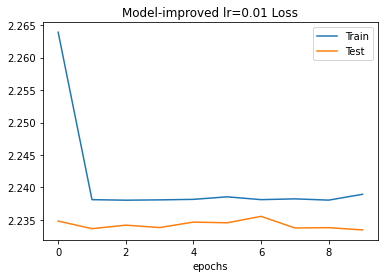

In [45]:
plot_loss('Model-improved lr=0.01 Loss', epochs, train_losses6, val_losses6)


In [46]:
batch_size = 64
epochs = 10
#loss_fn = torch.nn.CrossEntropyLoss()

train_dl, valid_dl = get_data(train_transformed, validation, batch_size)
model_cnn_improved_lr2, __ = get_model_cnn_improved()
opt = optim.Adam(model_cnn_improved_lr2.parameters(), lr=0.0001)

train_losses7, val_losses7, train_accs7, valid_accs7 = fit(epochs, model_cnn_improved_lr2, loss_fn, opt, train_dl, valid_dl)

0 train_loss=2.1236221258697854	val_loss=1.5914847310891804
1 train_loss=1.4475635353895027	val_loss=0.9040600966795396
2 train_loss=1.1336226357788002	val_loss=0.750153167583628
3 train_loss=0.988324176907163	val_loss=0.6566617019248732
4 train_loss=0.897832261510152	val_loss=0.5988307130847705
5 train_loss=0.8418619625713423	val_loss=0.5845048260792923
6 train_loss=0.7858771636241756	val_loss=0.5121049554075272
7 train_loss=0.7540217823211716	val_loss=0.5162071004741803
8 train_loss=0.7256520917681885	val_loss=0.46573349707379813
9 train_loss=0.7005399678441183	val_loss=0.43821325917696974


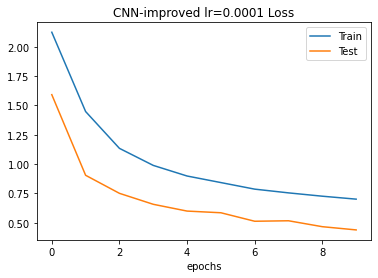

In [47]:
plot_loss('CNN-improved lr=0.0001 Loss', epochs, train_losses7, val_losses7)
